# BERT

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 27.8 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.4 MB/s 
     |████████████████████████████████| 596 kB 75.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 31.0 MB/s 
     |████████████████████████████████| 175 kB 61.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=c78ee04a12bc199f22f732ed24e08fa07a090218a5eaef49cf6cc9a4d49f6338
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
!pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 30.9 MB/s 


In [4]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 17.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [5]:
! pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 161 kB/s 
     |████████████████████████████████| 41 kB 127 kB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 8.2 MB 40.2 MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=a52a8af7015431a9252501a0582a44dbe27da01b104fb7b06c02a4b26457fef5
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [6]:
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import nltk
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

nltk.download('punkt')

import stanza
from collections import defaultdict
from tqdm.notebook import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter
import seaborn as sns
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Загружаем модель

In [7]:
PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

### Готовим данные

In [9]:
sents_data = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_data = sents_data.rename(columns = {'def' : 'has_def'}) 

In [10]:
shuffle =  sents_data.sample(frac=1).reset_index(drop=True) 

In [11]:
sents_data = shuffle[:750]
sents_data_test = shuffle[750:]

### Смотрим на данные

In [12]:
sents_data.head()

,Unnamed: 0,sent_index,sent_text,has_def
0,298,10143,"Вавило́нская ба́шня — башня, которой посвящено...",1
1,342,12960,Безли́чные предложе́ния — это односоставные пр...,1
2,772,1167,Основные функции косвенных залогов: «развёрты...,0
3,496,24582,Изменённые состояния сознания (ИСС) — качестве...,1
4,12,h_1,Аналогичным образом графика изучает свойства э...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


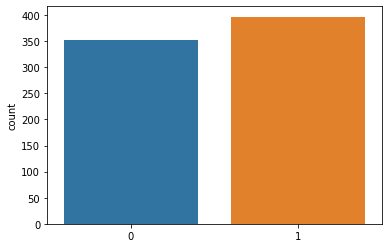

In [13]:
sns.countplot(list(sents_data['has_def']))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


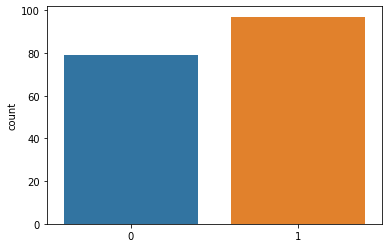

In [14]:
sns.countplot(list(sents_data_test['has_def']))

In [15]:
from statistics import mean
lens = [len(i.split(' ')) for i in list(sents_data['sent_text'])]
mean(lens)

21.64

### Датасет

In [16]:
class SentsDataset(Dataset):

  def __init__(self, sents, targets, tokenizer, max_len):
    self.sents = sents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sents)
  
  def __getitem__(self, item):
    sent = str(self.sents[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sent_text':sent,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [17]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
df_train, df_test = train_test_split(sents_data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(sents_data_test, test_size=0.5, random_state=RANDOM_SEED)

In [19]:
MAX_LEN = 128

### DataLoader

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentsDataset(
    sents=df.sent_text.to_numpy(),
    targets=df.has_def.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sent_text', 'input_ids', 'attention_mask', 'targets'])

### Класс SentsClassifier

In [23]:
class SentsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentsClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    return output[0]

In [24]:
model = SentsClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

#### Смотрим метрики

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sent_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sent_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sent_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sent_texts, predictions, prediction_probs, real_values

In [26]:
y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [27]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.19      0.14      0.16        36
           1       0.49      0.58      0.53        52

    accuracy                           0.40        88
   macro avg       0.34      0.36      0.34        88
weighted avg       0.37      0.40      0.38        88



#### Тестируем на каком-либо предложении

In [28]:
def predict(model, sentence):
    encoded_text = tokenizer.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True)
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    prediction = torch.argmax(output, dim=1)

    return prediction.cpu().numpy()[0]

In [29]:
predict(model, 'Любовь - это великое искусство.')

0

### Обучаем на наших данных

In [30]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bms_multiling_uncased_10.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.36335853556560915 accuracy 0.8518518518518519
Val loss 0.22506214678287506 accuracy 0.9318181818181819

Epoch 2/10
----------
Train loss 0.2307360405318959 accuracy 0.9362962962962963
Val loss 0.09379401771972577 accuracy 0.9772727272727273

Epoch 3/10
----------
Train loss 0.16002851369422535 accuracy 0.9540740740740741
Val loss 0.16056695487350225 accuracy 0.9545454545454546

Epoch 4/10
----------
Train loss 0.08127402360984233 accuracy 0.9792592592592592
Val loss 0.24831766825324544 accuracy 0.9431818181818182

Epoch 5/10
----------
Train loss 0.04478902188887776 accuracy 0.9896296296296295
Val loss 0.22918217082042247 accuracy 0.9545454545454546

Epoch 6/10
----------
Train loss 0.02771486809509698 accuracy 0.9955555555555555
Val loss 0.28667003253940493 accuracy 0.9431818181818182

Epoch 7/10
----------
Train loss 0.0269171190421032 accuracy 0.9955555555555555
Val loss 0.30466420331504196 accuracy 0.9431818181818182

Epoch 8/10
----------
Train l

#### Смотрим метрики

In [34]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9545454545454546

Ура! Выглядит неплохо...

In [35]:
y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [36]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.96      0.96      0.96        52

    accuracy                           0.95        88
   macro avg       0.95      0.95      0.95        88
weighted avg       0.95      0.95      0.95        88



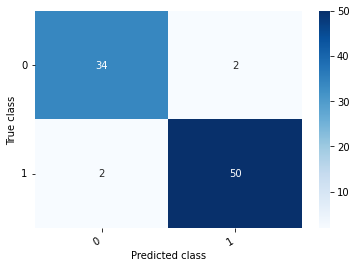

In [37]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
show_confusion_matrix(df_cm)

#### Тестируем на каком-либо предложении

In [38]:
predict(model, 'Лингивстика - это наука о языках, изучающая их как систему.')

1

# CRF без эмбеддингов

In [ ]:
from sklearn.model_selection import train_test_split
import stanza
from collections import defaultdict
from tqdm.notebook import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter
import pandas as pd
import seaborn as sns
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

### Готовим файлы

In [ ]:
df_sents = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_filtered = df_sents[df_sents['def'] > 0]
sents = list(sents_filtered['sent_text'])
ids = list(sents_filtered['sent_index'])

In [ ]:
train_sents, dev_sents, train_ids, dev_ids = train_test_split(sents, ids)

In [ ]:
df_tokens = pd.read_csv('tokens_Wiki_tagged.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_filtered = df_tokens[df_tokens['sent_index'].isin(ids)]
tokens = list(tokens_filtered['token'])
t_ids = list(tokens_filtered['sent_index'])

In [ ]:
def bio_sents(sents_ids, tokens_df):
    bio_sents = {}
    for i in sents_ids:
        bio_sents[i] = list(tokens_df.loc[tokens_df['sent_index']==i]['tag'])
    return bio_sents

In [ ]:
bio_sents_train = bio_sents(train_ids, df_tokens)
bio_sents_test = bio_sents(dev_ids, df_tokens)

In [ ]:
def word2features(sent, i):
    word = sent[i].text
    postag = sent[i].pos
    
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
    }
    if i > 0:
        word1 = sent[i-1].text
        postag1 = sent[i-1].pos
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1].text
        postag1 = sent[i+1].pos
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def text2features(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    m = doc.tag_morph(morph_tagger)
    toks = []
    for tok in doc.tokens:
        toks.append(tok)
    return [word2features(toks, i) for i in range(len(toks))]

def text2labels(text_ids, labels):
    return [labels[i] for i in text_ids]

def text2tokens(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    toks = []
    for sent in sentences:
      for tok in doc.tokens:
        toks.append(tok)
    return toks

In [ ]:
X_train = [text2features(s) for s in train_sents]
y_train = text2labels(train_ids, bio_sents_train)

X_test = [text2features(s) for s in dev_sents]
y_test = text2labels(dev_ids, bio_sents_test)

### Запускаем CRF

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

### Смотрим метрики

In [ ]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9117123383255811

In [ ]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-DEF      0.847     0.859     0.853       135
       I-DEF      0.923     0.953     0.938      2312
      B-TERM      0.958     0.772     0.855       149
      I-TERM      0.876     0.497     0.634       157

   micro avg      0.919     0.912     0.916      2753
   macro avg      0.901     0.770     0.820      2753
weighted avg      0.918     0.912     0.912      2753



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-DEF', 'I-DEF', 'B-TERM', 'I-TERM'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Как-то без эмбеддингов всё грустно.

### Тестируем на каком-либо предложении

In [ ]:
crf.predict(text2features(s) for s in ['Любовь - это великое искусство.'])

[['B-TERM', 'O', 'O', 'B-DEF', 'I-DEF', 'O']]

# Тестируем всё вместе на каком-либо предложении

In [ ]:
def predict_labels(inp):
    cls = predict(model, inp)
    if cls == 0:
        return 'Терминов и определений нет'
    else:
        return crf.predict(text2features(s) for s in [inp])

In [ ]:
predict_labels('В нынешнем виде это слово зафиксировано на польском языке в XV веке.')

'Терминов и определений нет'

In [ ]:
predict_labels('Стяже́ние (контракция) — слияние двух смежных гласных в один гласный или в дифтонг.')

[['B-TERM',
  'O',
  'B-TERM',
  'O',
  'O',
  'B-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'O']]

Кажется, неплохо!